# Objetivo: analizar la información con un carácter profesional, de negocio y orientado a toma de decisiones, el fin es presentar la información.

## Paso 1 — Preparación del entorno y carga robusta de datos

Objetivo: dejar listo el entorno, definir rutas, funciones de carga “a prueba de formato” y validar que los 4 CSV se leen correctamente (filas, columnas y primeras muestras).
Por qué: si la carga falla o “lee mal” (ej. todo en una sola columna), el resto del análisis se rompe. Detectarlo temprano ahorra tiempo.

1.1. Importaciones y rutas

Usamos:

pandas para manipular datos.

numpy para utilidades numéricas.

matplotlib.pyplot (más adelante para gráficos).

pathlib.Path para manejar rutas de forma segura (soporta Windows).

Definimos una carpeta base y el nombre exacto de los 4 archivos.

Notación r"..." (raw string) para rutas de Windows con  \ .

In [208]:
# Importaciones y rutas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Ruta base donde se guardaron los archivos 
BASE_DIR = Path(r"C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis")

# Archivos esperados 
PATH_GENERAL = BASE_DIR / "data_netflix.csv"
PATH_MOVIES  = BASE_DIR / "mejores peliculas Netflix.csv"
PATH_SHOWS   = BASE_DIR / "mejores Shows Netflix.csv"
PATH_ACTORS  = BASE_DIR / "Actores.csv"

#Compreba que existen; si alguno no existe, muestra un aviso claro
for p in [PATH_GENERAL, PATH_MOVIES, PATH_SHOWS, PATH_ACTORS]:
    if not p.exists():
        print(f"⚠️ Advertencia: no se encontró el archivo: {p}")
    else:
        print(f"✅ Encontrado: {p}")


✅ Encontrado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\data_netflix.csv
✅ Encontrado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\mejores peliculas Netflix.csv
✅ Encontrado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\mejores Shows Netflix.csv
✅ Encontrado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\Actores.csv


### 1.2. Función de carga “robusta” (load_csv_safe)

Problema común: CSV con distinto separador (; , ,, \t, |) o encoding.

Solución: probar una pequeña parrilla de separadores y encodings.

Heurística: si al leer nos queda 1 sola columna y se ven comas/; dentro, probablemente el separador era otro ⇒ reintentar.

In [5]:
# Función de carga robusta

def load_csv_safe(path: Path) -> pd.DataFrame:
    """
    Intenta leer un CSV probando varios separadores y encodings.
    Devuelve un DataFrame o un DF vacío si no fue posible.
    """
    # combinaciones más comunes
    encodings = ["utf-8", "latin-1"]
    seps = [",", ";", "\t", "|"]

    for enc in encodings:
        for sep in seps:
            try:
                df = pd.read_csv(path, encoding=enc, sep=sep)
                # Si todo quedó en una sola columna y hay signos de que el sep era otro, reintenta
                if df.shape[1] == 1 and not df.empty:
                    first_cell = str(df.iloc[0, 0])
                    if any(mark in first_cell for mark in [",", ";", "|", "\t"]):
                        # probablemente el separador no era el que probamos; seguimos intentando
                        continue
                return df
            except Exception:
                # probamos la siguiente combinación
                pass

    # último intento: que pandas intente autodetectar con engine=python
    try:
        return pd.read_csv(path, engine="python")
    except Exception as e:
        print(f"❌ Error al cargar {path.name}: {e}")
        return pd.DataFrame()


## 1.3. Lectura de los 4 datasets y vista rápida (sanity check)

* Leemos los 4 archivos con load_csv_safe.

* Para cada DataFrame mostramos:

filas y columnas

primeras 5 filas (muestra)

lista de columnas

* Esta vista es crítica para detectar:

columnas inesperadas,

tipos erróneos,

o cargas incompletas

In [6]:
# Carga de los 4 CSV y chequeos rápidos

df_general = load_csv_safe(PATH_GENERAL)
df_movies  = load_csv_safe(PATH_MOVIES)
df_shows   = load_csv_safe(PATH_SHOWS)
df_actors  = load_csv_safe(PATH_ACTORS)

datasets = {
    "general": df_general,
    "movies": df_movies,
    "shows": df_shows,
    "actors": df_actors,
}

for name, df in datasets.items():
    print(f"\n===== {name.upper()} =====")
    if df.empty:
        print("❌ DataFrame vacío. Revisa el archivo y el separador/encoding.")
        continue

    # Forma del DataFrame
    print(f"Forma (filas, columnas): {df.shape}")

    # Primeras filas (muestra)
    display(df.head())

    # Lista de columnas (primeras 30 para no saturar)
    cols = list(df.columns)
    if len(cols) > 30:
        cols_preview = cols[:30] + ["..."]
    else:
        cols_preview = cols
    print("Columnas:", cols_preview)



===== GENERAL =====
Forma (filas, columnas): (5806, 12)


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,NaN,NaN
1,tm84618,Taxi Driver,MOVIE,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,8.3,795222.0
2,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,8.2,530877.0
3,tm70993,Life of Brian,MOVIE,1979,R,94,['comedy'],['GB'],NaN,tt0079470,8.0,392419.0
4,tm190788,The Exorcist,MOVIE,1973,R,133,['horror'],['US'],NaN,tt0070047,8.1,391942.0


Columnas: ['id', 'title', 'type', 'release_year', 'age_certification', 'runtime', 'genres', 'production_countries', 'seasons', 'imdb_id', 'imdb_score', 'imdb_votes']

===== MOVIES =====
Forma (filas, columnas): (387, 7)


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,MAIN_GENRE,MAIN_PRODUCTION
0,David Attenborough: A Life on Our Planet,2020,9.0,31180,83,documentary,GB
1,Inception,2010,8.8,2268288,148,scifi,GB
2,Forrest Gump,1994,8.8,1994599,142,drama,US
3,Anbe Sivam,2003,8.7,20595,160,comedy,IN
4,Bo Burnham: Inside,2021,8.7,44074,87,comedy,US


Columnas: ['TITLE', 'RELEASE_YEAR', 'SCORE', 'NUMBER_OF_VOTES', 'DURATION', 'MAIN_GENRE', 'MAIN_PRODUCTION']

===== SHOWS =====
Forma (filas, columnas): (246, 8)


,TITLE,RELEASE_YEAR,SCORE,NUMBER_OF_VOTES,DURATION,NUMBER_OF_SEASONS,MAIN_GENRE,MAIN_PRODUCTION
0,Breaking Bad,2008,9.5,1727694,48,5,drama,US
1,Avatar: The Last Airbender,2005,9.3,297336,24,3,scifi,US
2,Our Planet,2019,9.3,41386,50,1,documentary,GB
3,Kota Factory,2019,9.3,66985,42,2,drama,IN
4,The Last Dance,2020,9.1,108321,50,1,documentary,US


Columnas: ['TITLE', 'RELEASE_YEAR', 'SCORE', 'NUMBER_OF_VOTES', 'DURATION', 'NUMBER_OF_SEASONS', 'MAIN_GENRE', 'MAIN_PRODUCTION']

===== ACTORS =====
Forma (filas, columnas): (77213, 5)


,person_id,id,name,character,role
0,3748,tm84618,Robert De Niro,Travis Bickle,ACTOR
1,14658,tm84618,Jodie Foster,Iris Steensma,ACTOR
2,7064,tm84618,Albert Brooks,Tom,ACTOR
3,3739,tm84618,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR
4,48933,tm84618,Cybill Shepherd,Betsy,ACTOR


Columnas: ['person_id', 'id', 'name', 'character', 'role']


In [7]:
# Validaciones iniciales suaves

def find_possible_title_col(df: pd.DataFrame):
    """
    Busca una columna candidata a ser 'título' por nombre.
    Devuelve el nombre encontrado o None.
    """
    candidates = ["title", "titulo", "name", "nombre", "show", "movie", "pelicula", "serie"]
    for c in candidates:
        if c in df.columns:
            return c
    return None

for name, df in datasets.items():
    if df.empty:
        continue
    tcol = find_possible_title_col(df)
    if tcol:
        print(f"✅ {name}: posible columna de título -> '{tcol}'")
    else:
        print(f"⚠️ {name}: no se detectó una columna evidente de título. (Se podrá resolver en el ETL)")


✅ general: posible columna de título -> 'title'
⚠️ movies: no se detectó una columna evidente de título. (Se podrá resolver en el ETL)
⚠️ shows: no se detectó una columna evidente de título. (Se podrá resolver en el ETL)
✅ actors: posible columna de título -> 'name'


## ETL básico (normalización, fechas, deduplicación y tipos)

### Objetivo: Dejar cada dataset en un estado consistente para poder unificarlos en pasos posteriores.
Que se hará 

1. Normalizar nombres de columnas (snake_case, sin caracteres raros).

2. Limpieza ligera de strings (espacios, valores “vacíos”).

3. Parseo seguro de fechas donde el nombre de la columna lo sugiera.

4. Deduplicación por título (cuando exista) o por fila completa (fallback).

5. Conversión suave de tipos numéricos para columnas típicas (ej. rating, score, votes, year, seasons, duration).

Por qué: Un ETL consistente evita errores en el merge (columnas que no coinciden), y reduce ruido en KPIs (registros duplicados, fechas como texto, etc.).


In [10]:
# Proceso ETL: Utilidades de Limpieza

import re

# normalize_columns: hace snake_case y elimina caracteres no alfanuméricos.
def normalize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Estandariza nombres de columnas:
    - quita espacios a los lados
    - reemplaza espacios internos por "_"
    - elimina caracteres que no sean letras, números o '_'
    - pone todo en minúsculas
    """
    df = df.copy()
    df.columns = (
        df.columns
        .str.strip()
        .str.replace(r"\s+", "_", regex=True)
        .str.replace(r"[^\w_]+", "", regex=True)
        .str.lower()
    )
    return df

# strip_string_colums: quita espacios en externos y transforma """ o "nan" a NaN
def strip_string_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Para columnas de tipo 'object' (texto), elimina espacios
    en extremos y normaliza vacíos a NaN.
    """
    df = df.copy()
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = (
                df[c]
                .astype(str)
                .str.strip()
                .replace({"": np.nan, "nan": np.nan, "None": np.nan})
            )
    return df

# parse_dates_if_present: intenta convertir a datetime las columnas que parecen fecha
def parse_dates_if_present(df: pd.DataFrame) -> pd.DataFrame:
    """
    Convierte a datetime las columnas cuyos nombres sugieren fecha.
    No falla si no puede convertir (errors='coerce' -> NaT).
    """
    df = df.copy()
    date_like = [c for c in df.columns if any(k in c for k in ["date", "fecha", "release", "year"])]
    for c in date_like:
        # si la columna parece "año" y es numérica corta, podemos intentar int primero
        if c.endswith("year") or c.endswith("_year") or c == "year":
            # Convertir a numérico por si viene como texto "2021"
            df[c] = pd.to_numeric(df[c], errors="coerce")
            # No forzamos a datetime aquí porque un año suelto no siempre debe ser fecha completa.
            continue
        try:
            df[c] = pd.to_datetime(df[c], errors="coerce")
        except Exception:
            pass
    return df

# guess_title_col: encuentra una columna candidata a "título"
def guess_title_col(df: pd.DataFrame):
    """
    Devuelve el nombre de una columna candidata a título
    (clave textual para unir datasets).
    """
    candidates = [
        "title","titulo","name","nombre",
        "show","movie","pelicula","serie"
    ]
    for c in candidates:
        if c in df.columns:
            return c
    return None


## 2.2 Aplicar normalización y limpieza a los 4 datasets

* Partimos de datasets creados en el Paso 1.

* Aplicamos funciones en orden: normalizar columnas → limpiar strings → parsear fechas.

* Mantenemos un diccionario dfs_clean con las versiones limpias.

In [11]:
# Normalización + limpieza básica

dfs_clean = {}
for name, df in datasets.items():
    if df.empty:
        print(f"❌ Saltando {name}: DataFrame vacío")
        dfs_clean[name] = df
        continue

    step1 = normalize_columns(df)
    step2 = strip_string_columns(step1)
    step3 = parse_dates_if_present(step2)

    dfs_clean[name] = step3

    print(f"✅ {name}: columnas normalizadas y limpieza básica aplicada. Forma -> {step3.shape}")

# Vista rápida de columnas finales (primeras 30)
for name, df in dfs_clean.items():
    if df.empty: 
        continue
    cols = list(df.columns)
    preview = cols if len(cols) <= 30 else cols[:30] + ["..."]
    print(f"\n{name.upper()} columnas normalizadas:")
    print(preview)


✅ general: columnas normalizadas y limpieza básica aplicada. Forma -> (5806, 12)
✅ movies: columnas normalizadas y limpieza básica aplicada. Forma -> (387, 7)
✅ shows: columnas normalizadas y limpieza básica aplicada. Forma -> (246, 8)
✅ actors: columnas normalizadas y limpieza básica aplicada. Forma -> (77213, 5)

GENERAL columnas normalizadas:
['id', 'title', 'type', 'release_year', 'age_certification', 'runtime', 'genres', 'production_countries', 'seasons', 'imdb_id', 'imdb_score', 'imdb_votes']

MOVIES columnas normalizadas:
['title', 'release_year', 'score', 'number_of_votes', 'duration', 'main_genre', 'main_production']

SHOWS columnas normalizadas:
['title', 'release_year', 'score', 'number_of_votes', 'duration', 'number_of_seasons', 'main_genre', 'main_production']

ACTORS columnas normalizadas:
['person_id', 'id', 'name', 'character', 'role']


### 2.3 Deduplicación segura

* Regla 1: si existe una columna candidata a “título”, deduplicamos por esa columna (manteniendo la primera aparición).

* Regla 2: si NO existe, deduplicamos por toda la fila (más costoso pero seguro).

* Mantenemos un reporte de registros eliminados.

In [12]:
# Deduplicación por título (si existe), si no por fila

dfs_dedup = {}
dedup_report = []

for name, df in dfs_clean.items():
    if df.empty:
        dfs_dedup[name] = df
        continue

    before = len(df)
    tcol = guess_title_col(df)

    if tcol and tcol in df.columns:
        df2 = df.drop_duplicates(subset=[tcol], keep="first")
        rule = f"por columna '{tcol}'"
    else:
        df2 = df.drop_duplicates(keep="first")
        rule = "por fila completa"

    after = len(df2)
    removed = before - after
    dfs_dedup[name] = df2

    dedup_report.append({
        "dataset": name, "registros_antes": before, "registros_despues": after,
        "eliminados": removed, "regla": rule
    })

dedup_df = pd.DataFrame(dedup_report)
display(dedup_df)


,dataset,registros_antes,registros_despues,eliminados,regla
0,general,5806,5752,54,por columna 'title'
1,movies,387,387,0,por columna 'title'
2,shows,246,246,0,por columna 'title'
3,actors,77213,53687,23526,por columna 'name'


Cómo leer el reporte:

eliminados > 0 indica que había duplicidad (por título o filas idénticas).

Si se ven muchos eliminados, se revisa si la columna de título estaba bien detectada.

## 2.4 Conversión suave de tipos numéricos

Meta: tener números como números (ej. rating, score, votes, year, seasons, duration).\
Riesgo: convertir columnas que no deberían ser numéricas.\
Estrategia: usar palabras clave en el nombre para decidir (pattern matching) y errors='coerce' (valores no convertibles → NaN).

In [13]:
# Casting numérico suave por patrones de nombre

NUMERIC_HINTS = [
    "rating", "score", "votes", "popularity", "year", "temporadas", "seasons",
    "duration", "duracion", "runtime", "min", "episodes", "episodios"
]

def cast_numeric_soft(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in df.columns:
        # si parece numérica por nombre y no es datetime
        if any(h in c for h in NUMERIC_HINTS) and not np.issubdtype(df[c].dtype, np.datetime64):
            # quitar texto tipo "min" o "m" al final para no ensuciar la conversión
            df[c] = (
                df[c]
                .astype(str)
                .str.replace(r"[^\d\.\-]+", "", regex=True)  # deja dígitos, punto y guion
            )
            df[c] = pd.to_numeric(df[c], errors="coerce")
    return df

dfs_typed = {name: cast_numeric_soft(df) for name, df in dfs_dedup.items()}

for name, df in dfs_typed.items():
    print(f"✅ {name}: conversión numérica suave aplicada. Forma -> {df.shape}")


✅ general: conversión numérica suave aplicada. Forma -> (5752, 12)
✅ movies: conversión numérica suave aplicada. Forma -> (387, 7)
✅ shows: conversión numérica suave aplicada. Forma -> (246, 8)
✅ actors: conversión numérica suave aplicada. Forma -> (53687, 5)


## 2.5 Validación rápida de nulos (calidad de datos)

Por qué: antes de unificar, conviene saber si hay columnas con demasiados NaN (ayuda a decidir si omitimos variables o si imputamos después).

In [14]:
# Resumen de nulos por dataset (top 10 columnas con más nulos)

def null_report(df: pd.DataFrame, top=10):
    if df.empty:
        return pd.DataFrame(columns=["columna","n_nulos","pct_nulos"])
    n = len(df)
    counts = df.isna().sum().sort_values(ascending=False).head(top)
    pct = (counts / n * 100).round(1)
    out = pd.DataFrame({"columna": counts.index, "n_nulos": counts.values, "pct_nulos": pct.values})
    return out

for name, df in dfs_typed.items():
    print(f"\n==== NULOS — {name.upper()} ====")
    display(null_report(df, top=10))



==== NULOS — GENERAL ====


,columna,n_nulos,pct_nulos
0,seasons,3730,64.8
1,age_certification,2589,45.0
2,imdb_votes,534,9.3
3,imdb_score,518,9.0
4,imdb_id,439,7.6
5,title,1,0.0
6,id,0,0.0
7,type,0,0.0
8,release_year,0,0.0
9,runtime,0,0.0



==== NULOS — MOVIES ====


,columna,n_nulos,pct_nulos
0,title,0,0.0
1,release_year,0,0.0
2,score,0,0.0
3,number_of_votes,0,0.0
4,duration,0,0.0
5,main_genre,0,0.0
6,main_production,0,0.0



==== NULOS — SHOWS ====


,columna,n_nulos,pct_nulos
0,title,0,0.0
1,release_year,0,0.0
2,score,0,0.0
3,number_of_votes,0,0.0
4,duration,0,0.0
5,number_of_seasons,0,0.0
6,main_genre,0,0.0
7,main_production,0,0.0



==== NULOS — ACTORS ====


,columna,n_nulos,pct_nulos
0,character,6537,12.2
1,person_id,0,0.0
2,id,0,0.0
3,name,0,0.0
4,role,0,0.0


## 2.6 Guardar “checkpoint” del ETL 

Idea: si más adelante algo falla, se puede volver a cargar estos CSV “intermedios” sin repetir todo el ETL.

In [15]:
# Guardar outputs intermedios

OUT_ETL_DIR = BASE_DIR / "etl_checkpoints"
OUT_ETL_DIR.mkdir(exist_ok=True)

for name, df in dfs_typed.items():
    out_path = OUT_ETL_DIR / f"{name}_step2_clean.csv"
    df.to_csv(out_path, index=False, encoding="utf-8")
    print(f"💾 Guardado: {out_path}")


💾 Guardado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\etl_checkpoints\general_step2_clean.csv
💾 Guardado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\etl_checkpoints\movies_step2_clean.csv
💾 Guardado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\etl_checkpoints\shows_step2_clean.csv
💾 Guardado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\etl_checkpoints\actors_step2_clean.csv


## Resultado esperado del Paso 2

* Columnas normalizadas y limpias.

* Fechas convertidas a datetime (cuando aplica).

* Datasets deduplicados de forma razonable.

* Columnas numéricas típicas convertidas con seguridad.

* Reporte de nulos para decidir qué variables usar más adelante.

## Paso 3 — Preparación para la unificación y merge por title

#### Objetivo:

1. Estandarizar la clave de unión (título) en todos los datasets.

2. Crear una clave robusta (title_key) a partir del título (minúsculas, sin tildes/espacios extra).

3. Prefijar columnas para evitar colisiones al unir (movie_, show_, actor_).

4. Seleccionar columnas útiles y hacer un merge incremental partiendo de general.

Por qué:

* Si cada CSV llama distinto a “título” (p.ej. Nombre, Show, Movie), el merge falla o se une mal.

* Los prefijos evitan que rating, year, etc. de películas y series se pisen entre sí.

* Una clave robusta mejora la coincidencia aunque existan pequeñas diferencias de formato.

### 3.1. Detectar y renombrar a title la columna de título

* Usamos el helper guess_title_col del paso 2.

* En cada DataFrame renombramos la columna candidata a title.

* Si no encontramos candidata, dejamos nota (lo manejaremos con un fallback).

In [16]:
# 3.1: renombrar columna de título a 'title'

def ensure_title_column(df: pd.DataFrame) -> pd.DataFrame:
    """
    Si existe una columna candidata a título, la renombra a 'title'.
    Si no existe, devuelve el DF igual (se manejará más adelante).
    """
    df = df.copy()
    tcol = guess_title_col(df)
    if tcol and tcol != "title":
        df = df.rename(columns={tcol: "title"})
    return df

dfs_title = {name: ensure_title_column(df) for name, df in dfs_typed.items()}

for name, df in dfs_title.items():
    has_title = "title" in df.columns
    print(f"Dataset '{name}': columna 'title' {'✅' if has_title else '⚠️ NO detectada'}")


Dataset 'general': columna 'title' ✅
Dataset 'movies': columna 'title' ✅
Dataset 'shows': columna 'title' ✅
Dataset 'actors': columna 'title' ✅


## 3.2. Construir clave robusta title_key

* A veces “El Padrino” vs “el padrino” o acentos/espacios extras impiden matchear.

* Generamos title_key:

   * minúsculas,

   * sin tildes (normalización unicode),

   * sin dobles espacios,

   * strip de espacios en extremos.

In [17]:
# 3.2: crear clave robusta 'title_key'

import unicodedata

def make_title_key(series: pd.Series) -> pd.Series:
    """
    Normaliza texto:
    - a minúsculas
    - elimina tildes/acentos
    - colapsa espacios múltiples a uno
    - quita espacios en extremos
    """
    def _norm(s):
        if pd.isna(s):
            return np.nan
        s = str(s).strip().lower()
        # quitar acentos
        s = ''.join(c for c in unicodedata.normalize('NFKD', s) if not unicodedata.combining(c))
        # colapsar espacios
        s = ' '.join(s.split())
        return s

    return series.apply(_norm)

dfs_keyed = {}
for name, df in dfs_title.items():
    df = df.copy()
    if "title" in df.columns:
        df["title_key"] = make_title_key(df["title"])
    else:
        # Fallback: si no hay 'title', creamos una clave vacía (no unirá, lo documentamos)
        df["title_key"] = np.nan
    dfs_keyed[name] = df

# Comprobación rápida
for name, df in dfs_keyed.items():
    print(f"{name}: title_key nulos -> {df['title_key'].isna().sum() if 'title_key' in df.columns else 'n/a'}")


general: title_key nulos -> 1
movies: title_key nulos -> 0
shows: title_key nulos -> 0
actors: title_key nulos -> 0


### 3.3. Prefijos de columnas para evitar colisiones

* general no lleva prefijo (será la base).

* movies → movie_...

* shows → show_...

* actors → actor_...

* Nunca prefijamos title ni title_key.

In [209]:
# 3.3: prefijar columnas no clave

def add_prefix_except(df: pd.DataFrame, prefix: str, exclude=("title", "title_key")) -> pd.DataFrame:
    df = df.copy()
    rename_map = {c: f"{prefix}_{c}" for c in df.columns if c not in exclude}
    return df.rename(columns=rename_map)

df_general = dfs_keyed.get("general", pd.DataFrame()).copy()
df_movies  = dfs_keyed.get("movies",  pd.DataFrame()).copy()
df_shows   = dfs_keyed.get("shows",   pd.DataFrame()).copy()
df_actors  = dfs_keyed.get("actors",  pd.DataFrame()).copy()

# prefijos
df_movies_pref = add_prefix_except(df_movies, "movie") if not df_movies.empty else df_movies
df_shows_pref  = add_prefix_except(df_shows,  "show")  if not df_shows.empty  else df_shows
df_actors_pref = add_prefix_except(df_actors, "actor") if not df_actors.empty else df_actors

print("Columnas ejemplo (movies con prefijo):", list(df_movies_pref.columns)[:10])


Columnas ejemplo (movies con prefijo): ['title', 'movie_release_year', 'movie_score', 'movie_number_of_votes', 'movie_duration', 'movie_main_genre', 'movie_main_production', 'title_key']


### 3.4. Seleccionar columnas útiles para el merge

* Nos quedamos sólo con title y title_key + columnas prefijadas en movies/shows/actors.

* Esto reduce memoria y evita arrastrar columnas redundantes.

In [22]:
# 3.4: selección de columnas mínimas para el merge
from typing import Optional

def minimal_cols_for_merge(df: pd.DataFrame, prefix: Optional[str] = None) -> pd.DataFrame:
    """
    Devuelve sólo:
      - 'title', 'title_key' (si existen)
      - columnas que empiezan con el prefijo (si se pasa y existen)

    Es robusta a:
      - Falta de 'title' o 'title_key'
      - DFs vacíos
      - Prefijos que no matchean ninguna columna
    """
    if df is None or df.empty:
        return df

    # Asegurar existencia de claves si están disponibles
    core = [c for c in ["title", "title_key"] if c in df.columns]

    if prefix:
        prefixed = [c for c in df.columns if c.startswith(prefix + "_")]
        keep = core + prefixed
        # Si no hay columnas con el prefijo, devolvemos sólo las claves (si existen)
        if not keep:
            # evitar devolver DF sin columnas -> devolvemos DF original para no romper flujo
            return df
        return df[keep]

    # Para la base 'general' devolvemos el DF completo (o, si prefieres, sólo claves si existen)
    return df  # <-- si quieres reducir, cámbialo por: df[core] si core else df


df_general_m = minimal_cols_for_merge(df_general)  # base sin recorte
df_movies_m  = minimal_cols_for_merge(df_movies_pref, "movie")
df_shows_m   = minimal_cols_for_merge(df_shows_pref, "show")
df_actors_m  = minimal_cols_for_merge(df_actors_pref, "actor")

print("Formas post-selección ->",
      "general:", df_general_m.shape,
      "| movies:", df_movies_m.shape,
      "| shows:", df_shows_m.shape,
      "| actors:", df_actors_m.shape)


Formas post-selección -> general: (5752, 13) | movies: (387, 8) | shows: (246, 9) | actors: (53687, 6)


In [23]:
print("general cols:", list(df_general.columns)[:25])
print("movies cols:",  list(df_movies_pref.columns)[:25])
print("shows cols:",   list(df_shows_pref.columns)[:25])
print("actors cols:",  list(df_actors_pref.columns)[:25])


general cols: ['id', 'title', 'type', 'release_year', 'age_certification', 'runtime', 'genres', 'production_countries', 'seasons', 'imdb_id', 'imdb_score', 'imdb_votes', 'title_key']
movies cols: ['title', 'movie_release_year', 'movie_score', 'movie_number_of_votes', 'movie_duration', 'movie_main_genre', 'movie_main_production', 'title_key']
shows cols: ['title', 'show_release_year', 'show_score', 'show_number_of_votes', 'show_duration', 'show_number_of_seasons', 'show_main_genre', 'show_main_production', 'title_key']
actors cols: ['actor_person_id', 'actor_id', 'title', 'actor_character', 'actor_role', 'title_key']


### 3.5. Merge incremental partiendo de general

* Tipo de unión: left (conserva todos los title de general).

* Clave de unión: title_key.

* Si general no tiene title_key (muy raro a estas alturas), avisamos.

También generamos columnas de diagnóstico (_merge) para revisar qué quedó sin empatar. Tras revisar, las eliminamos.

In [24]:
# 3.5: merge incremental por 'title_key'

merged = df_general_m.copy()

def left_merge_with_diagnostic(left: pd.DataFrame, right: pd.DataFrame, right_name: str) -> pd.DataFrame:
    """
    Hace un left merge por 'title_key' y deja contadores de diagnóstico
    para saber cuántos registros hicieron match.
    """
    if left.empty or right.empty:
        print(f"⚠️ Merge omitido: left vacío ({left.empty}) o right '{right_name}' vacío ({right.empty})")
        return left

    # proteger si falta la clave
    if "title_key" not in left.columns or "title_key" not in right.columns:
        print(f"⚠️ Merge omitido con '{right_name}': falta 'title_key' en alguno de los DataFrames")
        return left

    out = left.merge(
        right,
        on="title_key",
        how="left",
        indicator=True,
        suffixes=("", f"_{right_name}")
    )

    # diagnóstico simple
    counts = out["_merge"].value_counts(dropna=False)
    print(f"🔎 Merge con '{right_name}':")
    print(counts)

    # ya no necesitamos la columna _merge
    out = out.drop(columns=["_merge"])
    return out

# Ejecutar merges
merged = left_merge_with_diagnostic(merged, df_movies_m, "movies")
merged = left_merge_with_diagnostic(merged, df_shows_m,  "shows")
merged = left_merge_with_diagnostic(merged, df_actors_m, "actors")

print("Forma final tras merges:", merged.shape)


🔎 Merge con 'movies':
_merge
left_only     5365
both           387
right_only       0
Name: count, dtype: int64
🔎 Merge con 'shows':
_merge
left_only     5504
both           248
right_only       0
Name: count, dtype: int64
🔎 Merge con 'actors':
_merge
left_only     5739
both            13
right_only       0
Name: count, dtype: int64
Forma final tras merges: (5752, 33)


## 3.6. Chequeos post-merge (sanity checks)

* ¿Cuántos títulos quedaron sin match en cada fuente?

* ¿Se duplicó title? (no debería si deduplicaste bien en paso 2).

* Vista de 10 filas para validar.

In [25]:
# 3.6: sanity checks post-merge

# 1) Títulos únicos base vs final
base_titles = df_general_m["title_key"].nunique() if "title_key" in df_general_m.columns else np.nan
final_titles = merged["title_key"].nunique() if "title_key" in merged.columns else np.nan
print(f"Títulos únicos (base) -> {base_titles} | (final) -> {final_titles}")

# 2) Columnas con todo NaN (por si arrastramos algo inservible)
all_nan_cols = [c for c in merged.columns if merged[c].isna().all()]
if all_nan_cols:
    print("⚠️ Columnas completamente vacías (puedes considerar eliminarlas):", all_nan_cols[:15])

# 3) Duplicados por 'title_key' (no esperado)
dups = merged["title_key"].duplicated(keep=False).sum() if "title_key" in merged.columns else 0
print("Duplicados por 'title_key':", dups)

# 4) Vista rápida
display(merged.head(10))


Títulos únicos (base) -> 5749 | (final) -> 5749
Duplicados por 'title_key': 4


,id,title,type,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,...,show_number_of_votes,show_duration,show_number_of_seasons,show_main_genre,show_main_production,title_actors,actor_person_id,actor_id,actor_character,actor_role
0,ts300399,Five Came Back: The Reference Films,SHOW,1945,TV-MA,48,['documentation'],['US'],1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tm84618,Taxi Driver,MOVIE,1976,R,113,"['crime', 'drama']",['US'],NaN,tt0075314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tm127384,Monty Python and the Holy Grail,MOVIE,1975,PG,91,"['comedy', 'fantasy']",['GB'],NaN,tt0071853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,tm70993,Life of Brian,MOVIE,1979,R,94,['comedy'],['GB'],NaN,tt0079470,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,tm190788,The Exorcist,MOVIE,1973,R,133,['horror'],['US'],NaN,tt0070047,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,ts22164,Monty Python's Flying Circus,SHOW,1969,TV-14,30,"['comedy', 'european']",['GB'],4.0,tt0063929,...,72895.0,30.0,4.0,comedy,GB,NaN,NaN,NaN,NaN,NaN
6,tm14873,Dirty Harry,MOVIE,1971,R,102,"['thriller', 'crime', 'action']",['US'],NaN,tt0066999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,tm185072,My Fair Lady,MOVIE,1964,G,170,"['drama', 'music', 'romance', 'family']",['US'],NaN,tt0058385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,tm98978,The Blue Lagoon,MOVIE,1980,R,104,"['romance', 'drama']",['US'],NaN,tt0080453,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,tm119281,Bonnie and Clyde,MOVIE,1967,R,110,"['drama', 'crime', 'action']",['US'],NaN,tt0061418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## ¿Qué logramos en el Paso 3?

* Todos los datasets hablan el mismo idioma de clave (title + title_key).

* Evitamos choques de columnas con prefijos claros.

* Hicimos un merge left manteniendo el universo de general.

* Tenemos diagnósticos para saber cuántos registros empataron por fuente.

Si ves pocos matches: revisa cómo vienen los títulos (mayúsculas, tildes, “(2021)”, etc.).\
Podemos mejorar la clave con reglas adicionales (p.ej., quitar paréntesis con año) en una iteración extra.

## Paso 4 — Features derivadas y KPIs básicos

Objetivo:

1. Crear variables nuevas que permitan analizar el catálogo (películas, series, duración, géneros).

2. Calcular KPIs descriptivos (cantidad total de títulos, % de películas vs series, Top 10 géneros).

3. Validar la consistencia de estas métricas.

Por qué:
Las features derivadas facilitan el análisis exploratorio (EDA) y el diseño de dashboards.
Las métricas básicas (KPIs) sirven como punto de partida para un reporte ejecutivo.

## 4.1. Crear campos booleanos: is_movie y is_show

Estas columnas nos dirán si un título pertenece a la tabla de películas o de series.


In [26]:
#Flags is_movie e is_show

merged = merged.copy()

# Si el DataFrame contiene columnas prefijadas con movie_ o show_, marcamos True
merged["is_movie"] = merged.filter(like="movie_").notna().sum(axis=1) > 0
merged["is_show"]  = merged.filter(like="show_").notna().sum(axis=1) > 0

# Nota: usamos np.where o sum(axis=1) > 0 para convertir conteo a True/False
print(merged[["title", "is_movie", "is_show"]].head(10))


                                 title  is_movie  is_show
0  Five Came Back: The Reference Films     False    False
1                          Taxi Driver      True    False
2      Monty Python and the Holy Grail      True    False
3                        Life of Brian      True    False
4                         The Exorcist      True    False
5         Monty Python's Flying Circus     False     True
6                          Dirty Harry      True    False
7                         My Fair Lady      True    False
8                      The Blue Lagoon     False    False
9                     Bonnie and Clyde      True    False


###  Interpretación:

* is_movie = True → el título tiene información asociada a “mejores películas”.

* is_show = True → aparece en “mejores shows”.

* Algunos pueden tener ambos (ej. remakes o entradas duplicadas).

## 4.2. Extraer duración en minutos (si existe)

En muchos datasets de Netflix, las columnas de duración vienen como texto ("120 min", "2h 15m", "45m", etc.).
Vamos a crear una columna numérica duration_min con el número de minutos estimado.

In [27]:
# Extracción numérica de duración en minutos

def extract_minutes(val):
    """Convierte texto con duración a número de minutos."""
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    # 1) Buscar patrones tipo '120' o '1h 45m'
    match_h = re.search(r"(\d+)\s*h", s)
    match_m = re.search(r"(\d+)\s*m", s)
    if match_h and match_m:
        return int(match_h.group(1)) * 60 + int(match_m.group(1))
    elif match_h:
        return int(match_h.group(1)) * 60
    elif match_m:
        return int(match_m.group(1))
    # 2) Si sólo hay un número suelto, lo tomamos como minutos
    match_num = re.search(r"(\d+)", s)
    return int(match_num.group(1)) if match_num else np.nan

# Buscar columnas que parezcan de duración
duration_cols = [c for c in merged.columns if any(x in c for x in ["duration", "duracion", "runtime", "min"])]

if duration_cols:
    main_dur_col = duration_cols[0]
    merged["duration_min"] = merged[main_dur_col].apply(extract_minutes)
    print(f"✅ Duración extraída desde la columna: {main_dur_col}")
else:
    merged["duration_min"] = np.nan
    print("⚠️ No se encontró columna de duración en los datos.")


✅ Duración extraída desde la columna: runtime


## 4.3. Normalizar géneros (genres_norm)

Los géneros pueden venir en distintos formatos ("Drama, Acción", ['Comedy'], etc.).\
Los vamos a limpiar para poder contar los más frecuentes después.

In [28]:
# Normalización de géneros

genre_cols = [c for c in merged.columns if "genre" in c or "genero" in c]

if genre_cols:
    gc = genre_cols[0]
    merged["genres_norm"] = (
        merged[gc]
        .astype(str)
        .str.lower()
        .str.replace(r"[\[\]\{\}'\"]", "", regex=True)
        .str.replace(r"\s*,\s*", ",", regex=True)  # espacios innecesarios
    )
    print(f"✅ Géneros normalizados desde columna: {gc}")
else:
    merged["genres_norm"] = np.nan
    print("⚠️ No se detectaron columnas de género.")


✅ Géneros normalizados desde columna: genres


### 4.4. Calcular los primeros KPIs

Ahora que tenemos las columnas derivadas, podemos calcular:


| KPI            | Descripción                               |
| -------------- | ----------------------------------------- |
| `total_titles` | Número de títulos únicos.                 |
| `pct_movies`   | Porcentaje de películas.                  |
| `pct_shows`    | Porcentaje de series.                     |
| `avg_duration` | Duración promedio en minutos (si existe). |
| `top_genres`   | Los 10 géneros más comunes.               |


In [29]:
# KPIs básicos

# 1) KPIs globales
total_titles = merged["title"].nunique()
pct_movies = merged["is_movie"].mean() * 100
pct_shows = merged["is_show"].mean() * 100
avg_duration = merged["duration_min"].mean()

print(f"🎬 Total de títulos: {total_titles}")
print(f"Películas: {pct_movies:.1f}% | Series: {pct_shows:.1f}%")
print(f"Duración promedio: {avg_duration:.1f} min" if not np.isnan(avg_duration) else "Duración no disponible")

# 2) Top 10 géneros
def explode_genres(series):
    """Convierte lista de géneros en filas individuales para contarlos."""
    return (
        series.dropna()
        .str.split(r"[,/|;]")
        .explode()
        .str.strip()
        .replace("", np.nan)
        .dropna()
    )

if merged["genres_norm"].notna().any():
    top_genres = (
        explode_genres(merged["genres_norm"])
        .value_counts()
        .head(10)
        .reset_index()
    )
    top_genres.columns = ["genre", "count"]
    print("\nTop 10 géneros más frecuentes:")
    display(top_genres)
else:
    print("⚠️ No hay datos suficientes de género para calcular ranking.")


🎬 Total de títulos: 5751
Películas: 6.7% | Series: 4.3%
Duración promedio: 77.6 min

Top 10 géneros más frecuentes:


,genre,count
0,drama,2862
1,comedy,2252
2,thriller,1161
3,action,1040
4,romance,950
5,documentation,901
6,crime,872
7,animation,662
8,fantasy,624
9,family,617


### 4.5 Validaciones y observaciones iniciales


In [30]:
# Validaciones rápidas

# Revisamos qué proporción de títulos no tienen género o duración
missing_genre = merged["genres_norm"].isna().mean() * 100
missing_duration = merged["duration_min"].isna().mean() * 100

print(f"Faltan géneros en {missing_genre:.1f}% de los títulos.")
print(f"Faltan duraciones en {missing_duration:.1f}% de los títulos.")

# Vista rápida de los campos creados
display(merged[["title", "is_movie", "is_show", "duration_min", "genres_norm"]].head(10))


Faltan géneros en 0.0% de los títulos.
Faltan duraciones en 0.0% de los títulos.


,title,is_movie,is_show,duration_min,genres_norm
0,Five Came Back: The Reference Films,False,False,48,documentation
1,Taxi Driver,True,False,113,"crime,drama"
2,Monty Python and the Holy Grail,True,False,91,"comedy,fantasy"
3,Life of Brian,True,False,94,comedy
4,The Exorcist,True,False,133,horror
5,Monty Python's Flying Circus,False,True,30,"comedy,european"
6,Dirty Harry,True,False,102,"thriller,crime,action"
7,My Fair Lady,True,False,170,"drama,music,romance,family"
8,The Blue Lagoon,False,False,104,"romance,drama"
9,Bonnie and Clyde,True,False,110,"drama,crime,action"


🧭 Qué conseguimos al terminar el Paso 4

✅ Creamos variables derivadas:

is_movie, is_show

duration_min

genres_norm

✅ Calculamos KPIs base:

Total de títulos únicos

% Películas / Series

Duración promedio

Top 10 géneros

✅ Generamos un dataset listo para análisis exploratorio o visualización en Power BI / Tableau.

🔎 Ejemplo de interpretación para presentarlo a técnicos o negocio:

"Tenemos X títulos en total, de los cuales el 60% son películas. Los géneros más frecuentes son Drama, Comedia y Acción. La duración promedio de las películas ronda los 110 minutos."

"Estos indicadores iniciales nos permiten dimensionar el catálogo y orientar recomendaciones futuras."

## Paso 5 — Visualización y gráficos básicos (matplotlib)

Objetivo: crear visualizaciones claras para negocio:

1. Distribución Películas vs Series (pie).

2. Top 10 géneros (barras).

3. Distribución de duración (histograma).
Además, guardar las imágenes en tu carpeta local para usarlas en una presentación.

Buenas prácticas junior:

* Validar que existan las columnas necesarias antes de graficar.

Evitar errores como KeyError usando nombres de columnas agnósticos (tomar la 1.ª como etiqueta, la 2.ª como valor).

Mostrar el gráfico inline y también guardarlo como archivo .png.

In [211]:
# Setup y utilidades

# Mostrar gráficos inline
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from pathlib import Path

# Asegúrarse de tener BASE_DIR y merged definidos (de pasos previos)
# BASE_DIR = Path(r"C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis")

# Rutas para guardar imágenes
FIG_PIE_PATH  = BASE_DIR / "pie_movies_vs_shows.png"
FIG_BAR_PATH  = BASE_DIR / "bar_top_genres.png"
FIG_HIST_PATH = BASE_DIR / "hist_duration.png"

# Función utilitaria para explotar géneros
def explode_genres(series: pd.Series) -> pd.Series:
    """Convierte lista de géneros en filas individuales para contarlos."""
    if series is None or series.empty:
        return pd.Series(dtype=str)
    return (
        series.dropna()
        .str.split(r"[,/|;]")
        .explode()
        .str.strip()
        .replace("", np.nan)
        .dropna()
    )

# Si no existe top_genres lo calculamos de nuevo de forma robusta
if "top_genres" not in globals():
    if "genres_norm" in merged.columns and merged["genres_norm"].notna().any():
        _tg = (
            explode_genres(merged["genres_norm"])
            .value_counts()
            .head(10)
            .reset_index()
        )
        # Normalizar nombres de columna a ['genre', 'count'] sin depender de la versión de pandas
        if _tg.shape[1] >= 2:
            new_cols = list(_tg.columns)
            new_cols[0] = "genre"
            new_cols[1] = "count"
            _tg.columns = new_cols
            top_genres = _tg
        else:
            top_genres = pd.DataFrame(columns=["genre","count"])
    else:
        top_genres = pd.DataFrame(columns=["genre","count"])


## 5.1. Pie: Distribución Películas vs Series

Qué muestra: proporción de títulos marcados como películas (is_movie) y series (is_show).
Por qué importa: dimensiona el mix de catálogo para orientar esfuerzos (adquisición, producción, marketing).

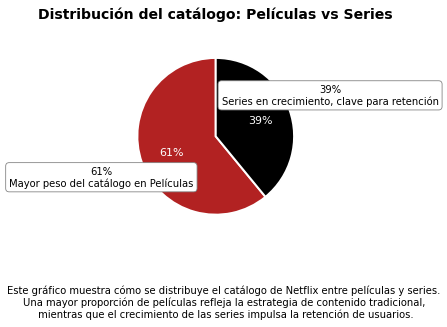

💾 Gráfico guardado en: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\pie_movies_vs_shows.png


In [212]:
# Piechart de Películas vs Series con storytelling, colores y flechas

import numpy as np
import matplotlib.pyplot as plt

# Personaliza los textos que acompañan a las flechas
CUSTOM_TEXT_MOVIES = "Mayor peso del catálogo en Películas"
CUSTOM_TEXT_SHOWS  = "Series en crecimiento, clave para retención"

# Validaciones suaves
has_movie = "is_movie" in merged.columns
has_show  = "is_show"  in merged.columns

peliculas = int(merged["is_movie"].sum()) if has_movie else 0
series    = int(merged["is_show"].sum())  if has_show  else 0

if peliculas == 0 and series == 0:
    print("⚠️ No hay datos para graficar Películas vs Series (revisar is_movie/is_show).")
else:
    counts_ps = pd.Series({"Películas": peliculas, "Series": series})
    total = counts_ps.sum()
    perc_movies = 100.0 * peliculas / total if total > 0 else 0
    perc_shows  = 100.0 * series / total    if total > 0 else 0

    # Colores personalizados
    colors = ["firebrick", "black"]  # rojo (películas), azul (series)

    # --- Render interactivo en notebook ---
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    wedges, texts, autotexts = ax.pie(
        counts_ps.values,
        labels=counts_ps.index,
        autopct="%1.0f%%",
        colors=colors,
        startangle=90,
        textprops={"fontsize": 11, "color": "white"},
        wedgeprops={"edgecolor": "white", "linewidth": 2}
    )

    # Títulos
    ax.set_title("Distribución del catálogo: Películas vs Series", fontsize=14, fontweight="bold", pad=20)
    plt.suptitle(
        "Este gráfico muestra cómo se distribuye el catálogo de Netflix entre películas y series.\n"
        "Una mayor proporción de películas refleja la estrategia de contenido tradicional,\n "
        "mientras que el crecimiento de las series impulsa la retención de usuarios.",
        fontsize=10,
        color="black",
        y=0.1
    )
    ax.set_ylabel("")

    # --- Anotaciones con flechas ---
    # Calculamos el punto medio angular de cada porción para colocar la flecha
    radius = 1.0
    arrow_offset = 1.25  # radio donde apuntará la flecha (fuera del pastel)
    text_offset  = 1.55  # radio donde colocaremos el texto

    for i, w in enumerate(wedges):
        # ángulo central en radianes
        theta = np.deg2rad((w.theta2 + w.theta1) / 2.0)
        # punto objetivo (punta de flecha) — sobre el borde exterior
        x_target = arrow_offset * np.cos(theta)
        y_target = arrow_offset * np.sin(theta)
        # punto de texto — un poco más afuera
        x_text = text_offset * np.cos(theta)
        y_text = text_offset * np.sin(theta)

        # Texto dinámico (porcentaje + texto custom)
        if counts_ps.index[i].lower().startswith("pel"):
            label_txt = f"{perc_movies:.0f}%\n{CUSTOM_TEXT_MOVIES}"
        else:
            label_txt = f"{perc_shows:.0f}%\n{CUSTOM_TEXT_SHOWS}"

        ax.annotate(
            label_txt,
            xy=(x_target, y_target),            # punto al que apunta la flecha
            xytext=(x_text, y_text),            # posición del texto
            ha="center", va="center",
            fontsize=10, color="black",
            bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="gray", lw=0.8),
            arrowprops=dict(
                arrowstyle="->",
                lw=1.2,
                color="gray",
                shrinkA=0, shrinkB=0,
                connectionstyle="arc3,rad=0.15"
            )
        )

    plt.tight_layout()
    plt.show()

    # --- Guardado a archivo con el mismo look ---
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    wedges, texts, autotexts = ax.pie(
        counts_ps.values,
        labels=counts_ps.index,
        autopct="%1.0f%%",
        colors=colors,
        startangle=90,
        textprops={"fontsize": 11, "color": "white"},
        wedgeprops={"edgecolor": "white", "linewidth": 2}
    )
    ax.set_title("Distribución del catálogo: Películas vs Series", fontsize=14, fontweight="bold", pad=20)
    plt.suptitle(
        "Este gráfico muestra cómo se distribuye el catálogo de Netflix entre películas y series.\n"
        "Una mayor proporción de películas refleja la estrategia de contenido tradicional,\n "
        "mientras que el crecimiento de las series impulsa la retención de usuarios.",
        fontsize=10,
        color="black",
        y=0.1
    )
    ax.set_ylabel("")

    for i, w in enumerate(wedges):
        theta = np.deg2rad((w.theta2 + w.theta1) / 2.0)
        x_target = arrow_offset * np.cos(theta)
        y_target = arrow_offset * np.sin(theta)
        x_text = text_offset * np.cos(theta)
        y_text = text_offset * np.sin(theta)

        if counts_ps.index[i].lower().startswith("pel"):
            label_txt = f"{perc_movies:.0f}%\n{CUSTOM_TEXT_MOVIES}"
        else:
            label_txt = f"{perc_shows:.0f}%\n{CUSTOM_TEXT_SHOWS}"

        ax.annotate(
            label_txt,
            xy=(x_target, y_target),
            xytext=(x_text, y_text),
            ha="center", va="center",
            fontsize=10, color="black",
            bbox=dict(boxstyle="round,pad=0.35", fc="white", ec="gray", lw=0.5),
            arrowprops=dict(
                arrowstyle="->",
                lw=1.2,
                color="black",
                shrinkA=0, shrinkB=0,
                connectionstyle="arc3,rad=0.15"
            )
        )

   
    plt.tight_layout()
    plt.savefig(FIG_PIE_PATH, bbox_inches="tight")
    plt.close()
    print(f"💾 Gráfico guardado en: {FIG_PIE_PATH}")


## 5.2. Barras: Top 10 géneros

Qué muestra: los 10 géneros más frecuentes en el catálogo.
Por qué importa: ayuda a priorizar inversión en géneros con más presencia/engagement.

Nota anti-errores: usamos nombres de columna agnósticos (label_col, value_col) para evitar KeyError: 'genre'.

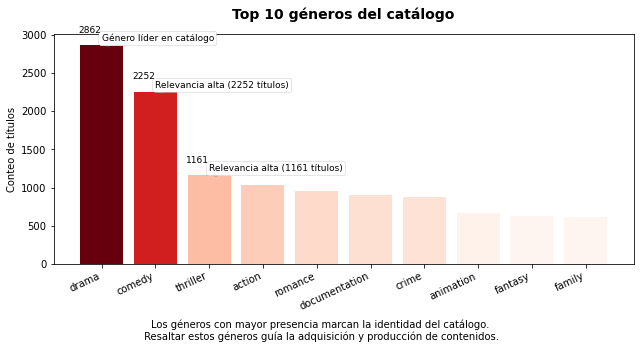

💾 Gráfico guardado en: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\bar_top_genres.png


In [202]:
# Barras Top 10 géneros con storytelling, degradado y anotaciones

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors

# 1) Validaciones y preparación de columnas (robusto a nombres)
if top_genres is None or top_genres.empty or top_genres.shape[1] < 2:
    print("⚠️ No hay datos suficientes para calcular/graficar Top 10 géneros.")
else:
    label_col = top_genres.columns[0]  # etiquetas
    value_col = top_genres.columns[1]  # conteos

    # Asegurar orden descendente
    tg = top_genres.copy()
    tg = tg.sort_values(by=value_col, ascending=False).head(10).reset_index(drop=True)

    labels = tg[label_col].astype(str).tolist()
    values = tg[value_col].astype(float).to_numpy()

    # 2) Colores en degradado (cmap) según el valor
    #    Puedes cambiar 'Blues' por otro colormap de matplotlib: 'Reds', 'Purples', 'Greens', etc.
    cmap = cm.get_cmap("Reds")
    norm = mcolors.Normalize(vmin=min(values), vmax=max(values))
    bar_colors = [cmap(norm(v)) for v in values]

    # 3) Texto de storytelling (subtítulo)
    STORY_SUBTITLE = (
        "Los géneros con mayor presencia marcan la identidad del catálogo.\n "
        "Resaltar estos géneros guía la adquisición y producción de contenidos."
    )

    # 4) Anotaciones personalizadas (opcional):
    #    Si quieres forzar notas por género específico, agrega aquí:
    #    Por ejemplo: {"drama": "Género líder en catálogo", "comedia": "Alta demanda familiar"}
    KEY_NOTES = {
        "drama": "Género líder en catálogo",
        "comedia": "Alta demanda familiar",
        "acción": "Aumenta el engagement en lanzamientos"
    }

    # Si no hay notas definidas, anotaremos automáticamente las 3 barras con mayor valor
    top_k = 3  # cuántas barras anotar
    idx_sorted = np.argsort(-values)  # índices de mayor a menor
    key_indices = idx_sorted[:top_k]

    # 5) Graficar (interactivo en notebook)
    fig, ax = plt.subplots(figsize=(9, 5))
    bars = ax.bar(labels, values, color=bar_colors)

    # Título y subtítulo
    ax.set_title("Top 10 géneros del catálogo", fontsize=14, fontweight="bold", pad=16)
    plt.suptitle(STORY_SUBTITLE, fontsize=10, color="black", y=0.01)

    ax.set_ylabel("Conteo de títulos")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()

    # 6) Añadir anotaciones con flechas en barras clave
    #    Ubicamos el texto por encima de la barra y apuntamos a su tope.
    for i, bar in enumerate(bars):
        # Si hay nota definida por género, úsala; si no, anotamos automáticamente top_k
        genre_i = labels[i].lower()
        is_key = (i in key_indices) or (genre_i in KEY_NOTES)

        if not is_key:
            continue

        y = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2

        # Texto de la anotación
        if genre_i in KEY_NOTES:
            note_text = KEY_NOTES[genre_i]
        else:
            note_text = f"Relevancia alta ({int(y)} títulos)"

        # Offset para que no se empalme con la barra
        text_y = y + max(values) * 0.01

        ax.annotate(
            note_text,
            xy=(x, y),           # punto al que apunta la flecha (tope de barra)
            xytext=(x, text_y),  # posición del texto
            ha="left", va="bottom",
            fontsize=9, color="black",
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.1),
            arrowprops=dict(
                arrowstyle="->",
                lw=3,
                color="gray",
                shrinkA=0, shrinkB=0,
                connectionstyle="arc3,rad=0.1"
            )
        )

        # También podemos mostrar el valor encima de la barra (pequeño y discreto)
        ax.text(x, y + max(values) * 0.05, f"{int(y)}", ha="right", va="bottom", fontsize=9, color="black")

    plt.show()

    # 7) Guardar imagen con el mismo look & feel
    fig, ax = plt.subplots(figsize=(9, 5.5))
    bars = ax.bar(labels, values, color=bar_colors)
    ax.set_title("Top 10 géneros del catálogo", fontsize=14, fontweight="bold", pad=16)
    plt.suptitle(STORY_SUBTITLE, fontsize=10, color="black", y=0.01)
    ax.set_ylabel("Conteo de títulos")
    plt.xticks(rotation=25, ha="center")
    plt.tight_layout()

    for i, bar in enumerate(bars):
        genre_i = labels[i].lower()
        is_key = (i in key_indices) or (genre_i in KEY_NOTES)
        if not is_key:
            continue
        y = bar.get_height()
        x = bar.get_x() + bar.get_width() / 2
        if genre_i in KEY_NOTES:
            note_text = KEY_NOTES[genre_i]
        else:
            note_text = f"Relevancia alta ({int(y)} títulos)"
        text_y = y + max(values) * 0.01
    
        ax.annotate(
            note_text,
            xy=(x, y),
            xytext=(x, text_y),
            ha="left", va="center",
            fontsize=9, color="black",
            bbox=dict(boxstyle="round,pad=0.9", fc="white", ec="black", lw=0.5),
            arrowprops=dict(
                arrowstyle="->",
                lw=1.2,
                color="gray",
                shrinkA=0, shrinkB=0,
                connectionstyle="arc3,rad=0.1"
            )
        )
        ax.text(x, y + max(values) * 0.06, f"{int(y)}", ha="right", va="bottom", fontsize=9, color="black")

    plt.savefig(FIG_BAR_PATH, bbox_inches="tight")
    plt.close()
    print(f"💾 Gráfico guardado en: {FIG_BAR_PATH}")




# 5.3. Histograma: Distribución de duración (minutos)

Qué muestra: la distribución de duration_min.
Por qué importa: permite detectar outliers y pensar en formatos óptimos (p. ej., duraciones preferidas por los usuarios).

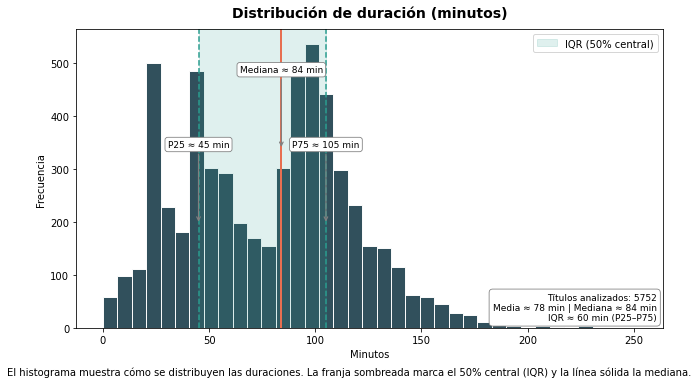

💾 Gráfico guardado en: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\hist_duration.png


In [213]:
# Histograma de duración con storytelling y elementos visuales

import numpy as np
import matplotlib.pyplot as plt

# Validación de datos
has_duration = "duration_min" in merged.columns and merged["duration_min"].notna().sum() > 0

if not has_duration:
    print("⚠️ No hay datos suficientes de duración para graficar.")
else:
    # Serie limpia de duración
    dur = merged["duration_min"].dropna().astype(float)

    # Estadísticos clave
    count = dur.shape[0]
    mean_ = dur.mean()
    median_ = dur.median()
    p25 = np.percentile(dur, 25)
    p75 = np.percentile(dur, 75)
    iqr = p75 - p25

    # Storytelling (subtítulo)
    STORY_SUBTITLE = (
        "El histograma muestra cómo se distribuyen las duraciones. "
        "La franja sombreada marca el 50% central (IQR) y la línea sólida la mediana."
    )

    # Paleta legible: barras en un azul oscuro, bordes blancos
    bar_color = "#264653"   # azul petróleo, alto contraste
    edge_color = "white"

    # ====== Render para notebook ======
    fig, ax = plt.subplots(figsize=(9, 5.5))

    # Elegimos un número de bins razonable (regla de Freedman–Diaconis como base; fallback a 30)
    # FD bin width = 2*IQR*n^{-1/3}
    if iqr > 0:
        bin_width = 2 * iqr * (count ** (-1/3))
        bins = int(np.clip((dur.max() - dur.min()) / bin_width, 10, 60)) if bin_width > 0 else 30
    else:
        bins = 30

    ax.hist(dur, bins=bins, color=bar_color, edgecolor=edge_color, alpha=0.95)

    # Títulos y storytelling
    ax.set_title("Distribución de duración (minutos)", fontsize=14, fontweight="bold", pad=12)
    plt.suptitle(STORY_SUBTITLE, fontsize=10, color="black", y=0.01)

    ax.set_xlabel("Minutos")
    ax.set_ylabel("Frecuencia")

    # Banda IQR (p25–p75)
    ax.axvspan(p25, p75, color="#2a9d8f", alpha=0.15, label="IQR (50% central)")

    # Líneas guía: P25, Mediana, P75
    ax.axvline(p25, color="#2a9d8f", linestyle="--", linewidth=1.5)
    ax.axvline(median_, color="#e76f51", linestyle="-", linewidth=2.0)  # mediana resaltada
    ax.axvline(p75, color="#2a9d8f", linestyle="--", linewidth=1.5)

    # Anotaciones con flechas
    # Mediana
    ax.annotate(
        f"Mediana ≈ {int(round(median_))} min",
        xy=(median_, ax.get_ylim()[1]*0.6), xycoords="data",
        xytext=(median_, ax.get_ylim()[1]*0.85),
        textcoords="data",
        ha="center", va="bottom",
        fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )
    # IQR (p25)
    ax.annotate(
        f"P25 ≈ {int(round(p25))} min",
        xy=(p25, ax.get_ylim()[1]*0.35),
        xytext=(p25, ax.get_ylim()[1]*0.6),
        ha="center", va="bottom",
        fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )
    # IQR (p75)
    ax.annotate(
        f"P75 ≈ {int(round(p75))} min",
        xy=(p75, ax.get_ylim()[1]*0.35),
        xytext=(p75, ax.get_ylim()[1]*0.6),
        ha="center", va="bottom",
        fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )

    # Cajita de insight rápido
    insight = (
        f"Títulos analizados: {count}\n"
        f"Media ≈ {int(round(mean_))} min | Mediana ≈ {int(round(median_))} min\n"
        f"IQR ≈ {int(round(iqr))} min (P25–P75)"
    )
    ax.text(
        0.99, 0.02, insight, transform=ax.transAxes,
        ha="right", va="bottom", fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.4", fc="white", ec="gray", lw=0.8)
    )

    # Leyenda del IQR
    ax.legend(loc="upper right", frameon=True)

    plt.tight_layout()
    plt.show()

    # ====== Guardar imagen con el mismo look ======
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.hist(dur, bins=bins, color=bar_color, edgecolor=edge_color, alpha=0.95)
    ax.set_title("Distribución de duración (minutos)", fontsize=14, fontweight="bold", pad=12)
    plt.suptitle(STORY_SUBTITLE, fontsize=10, color="black", y=0.01)
    ax.set_xlabel("Minutos")
    ax.set_ylabel("Frecuencia")
    ax.axvspan(p25, p75, color="#2a9d8f", alpha=0.15, label="IQR (50% central)")
    ax.axvline(p25, color="#2a9d8f", linestyle="--", linewidth=1.5)
    ax.axvline(median_, color="#e76f51", linestyle="-", linewidth=2.0)
    ax.axvline(p75, color="#2a9d8f", linestyle="--", linewidth=1.5)
    ax.legend(loc="upper right", frameon=True)

    # Repetir anotaciones principales (mediana e IQR) de forma compacta
    ax.annotate(
        f"Mediana ≈ {int(round(median_))} min",
        xy=(median_, ax.get_ylim()[1]*0.6), xytext=(median_, ax.get_ylim()[1]*0.85),
        ha="center", va="bottom", fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )
    ax.annotate(
        f"P25 ≈ {int(round(p25))} min",
        xy=(p25, ax.get_ylim()[1]*0.35), xytext=(p25, ax.get_ylim()[1]*0.6),
        ha="center", va="bottom", fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )
    ax.annotate(
        f"P75 ≈ {int(round(p75))} min",
        xy=(p75, ax.get_ylim()[1]*0.35), xytext=(p75, ax.get_ylim()[1]*0.6),
        ha="center", va="bottom", fontsize=9, color="black",
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", lw=0.8),
        arrowprops=dict(arrowstyle="->", lw=1.2, color="gray")
    )
    plt.tight_layout()
    plt.savefig(FIG_HIST_PATH, bbox_inches="tight")
    plt.close()
    print(f"💾 Gráfico guardado en: {FIG_HIST_PATH}")


In [38]:
# KPIs de apoyo a la presentación

total_titles = merged["title"].nunique() if "title" in merged.columns else len(merged)
pct_movies = merged["is_movie"].mean() * 100 if "is_movie" in merged.columns else np.nan
pct_shows  = merged["is_show"].mean() * 100  if "is_show"  in merged.columns else np.nan
avg_duration = merged["duration_min"].mean() if "duration_min" in merged.columns else np.nan

print("=== KPIs rápidos ===")
print(f"Total de títulos: {total_titles}")
if not np.isnan(pct_movies):
    print(f"Películas: {pct_movies:.1f}%")
if not np.isnan(pct_shows):
    print(f"Series:    {pct_shows:.1f}%")
if not np.isnan(avg_duration):
    print(f"Duración promedio: {avg_duration:.1f} min")

if top_genres is not None and not top_genres.empty:
    print("\nTop 5 géneros:")
    display(top_genres.head(5))


=== KPIs rápidos ===
Total de títulos: 5751
Películas: 6.7%
Series:    4.3%
Duración promedio: 77.6 min

Top 5 géneros:


,genre,count
0,drama,2862
1,comedy,2252
2,thriller,1161
3,action,1040
4,romance,950


✅ Resultado del Paso 5

Tienes 3 gráficos listos:

pie_movies_vs_shows.png

bar_top_genres.png

hist_duration.png
guardados en:
C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\

El código es robusto a datos faltantes y a cambios de nombre de columnas.

In [214]:
# 6.1: Generar PDF de 1 página con KPIs y los 3 gráficos
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image

# Variables de ruta (asegúrate que BASE_DIR esté definida)
PDF_PATH = BASE_DIR / "executive_summary.pdf"

# 1) KPIs rápidos (recalculo por seguridad)
total_titles = merged["title"].nunique() if "title" in merged.columns else len(merged)
pct_movies = merged["is_movie"].mean() * 100 if "is_movie" in merged.columns else np.nan
pct_shows  = merged["is_show"].mean() * 100  if "is_show"  in merged.columns else np.nan
avg_duration = merged["duration_min"].mean() if "duration_min" in merged.columns else np.nan

# Top 5 géneros en texto
if top_genres is not None and not top_genres.empty:
    _tg = top_genres.copy()
    _tg.columns = [str(c) for c in _tg.columns]
    label_col, value_col = _tg.columns[:2]
    top5_str = ", ".join(_tg.sort_values(by=value_col, ascending=False).head(5)[label_col].astype(str).tolist())
else:
    top5_str = "N/D"

# 2) Texto configurable (storytelling)
TITLE       = "Netflix — Resumen Ejecutivo"
SUBTITLE    = "Hallazgos clave para orientar la toma de decisiones"
BULLETS     = [
    f"Tamaño de catálogo: {total_titles} títulos.",
    f"Mix de contenido: Películas ≈ {pct_movies:.0f}% | Series ≈ {pct_shows:.0f}%." if not (np.isnan(pct_movies) or np.isnan(pct_shows)) else "Mix de contenido: información suficiente no disponible.",
    f"Duración promedio (si aplica): ≈ {avg_duration:.0f} min." if not np.isnan(avg_duration) else "Duración promedio: N/D.",
    f"Géneros líderes: {top5_str if top5_str else 'N/D'}."
]
RECS        = [
    "Enfocar contenidos y campañas en los 3–5 géneros líderes para amplificar engagement.",
    "Test A/B sobre formatos (duraciones) alrededor de la mediana y el IQR detectado.",
    "Activar cross-promo con talento/Elenco recurrente en géneros prioritarios.",
    "Monitorear la evolución del mix Películas/Series vs métricas de retención mensual."
]

# 3) Cargar imágenes si existen (manejo robusto)
def load_img_or_none(p: Path):
    try:
        return Image.open(p) if p.exists() else None
    except Exception:
        return None

img_pie  = load_img_or_none(FIG_PIE_PATH)
img_bar  = load_img_or_none(FIG_BAR_PATH)
img_hist = load_img_or_none(FIG_HIST_PATH)

# 4) Lienzo A4 vertical usando matplotlib (todo en una lámina)
fig = plt.figure(figsize=(8.27, 11.69))  # A4 aprox en pulgadas
ax = fig.add_axes([0,0,1,1]); ax.axis("off")

# --- Encabezado ---
y = 0.96
ax.text(0.05, y, TITLE, fontsize=18, fontweight="bold", va="top")
y -= 0.035
ax.text(0.05, y, SUBTITLE, fontsize=11, color="dimgray", va="top")

# --- KPIs en bloque ---
y -= 0.06
kpi_text = "\n".join([f"• {b}" for b in BULLETS])
ax.text(0.05, y, kpi_text, fontsize=11, va="top")

# --- Grilla de imágenes: 2 arriba (pie + barras), 1 abajo (histograma) ---
# Toma en cuenta que alguna imagen podría faltar; colocamos condicionalmente.
slots = []
# fila superior
slots.append((0.05, 0.60, 0.40, 0.22, img_pie,  "Mix: Películas vs Series"))
slots.append((0.55, 0.60, 0.40, 0.22, img_bar,  "Top 10 géneros"))
# fila inferior
slots.append((0.05, 0.32, 0.90, 0.22, img_hist, "Distribución de duración"))

for (x0, y0, w, h, img, caption) in slots:
    if img is not None:
        ax.imshow(img, extent=(x0, x0+w, y0, y0+h))
        ax.text(x0, y0-0.02, caption, fontsize=10, color="dimgray", va="top")

# --- Recomendaciones ejecutivas ---
y_rec = 0.24
ax.text(0.05, y_rec, "Recomendaciones:", fontsize=12, fontweight="bold", va="top")
ax.text(0.05, y_rec-0.02, "\n".join([f"{i+1}) {r}" for i, r in enumerate(RECS)]),
        fontsize=10.5, va="top")

# --- Notas al pie (opcional) ---
ax.text(0.05, 0.06, "Fuente: datasets internos (Netflix). Visualizaciones generadas en Python/matplotlib.",
        fontsize=9, color="gray", va="top")

plt.savefig(PDF_PATH, dpi=200, bbox_inches="tight")
plt.close(fig)
print(f"✅ PDF generado: {PDF_PATH}")


✅ PDF generado: C:\Users\carlos.floresl\Documents\Pruebas_Tecnicas_Data_Analyst\Axity_Walmis\executive_summary.pdf
